In [2]:
!pip install biosignalsnotebooks numpy scipy matplotlib
!pip install EMD-signal

import biosignalsnotebooks as bsnb

from numpy import linspace, max, min, average, std, sqrt, where, argmax
from scipy.integrate import cumtrapz
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np
import pywt
from scipy.signal import lfilter, iirfilter
from PyEMD import EEMD
import os  # Importa el módulo os aquí

from scipy.integrate import cumulative_trapezoid  # Importar la función adecuada

In [3]:
# Frecuencia de muestreo
frecuencia_muestreo = 1000  # Hz

# Frecuencia de corte del filtro IIR
cutoff_frequency_iir = 0.10  # Frecuencia de corte para el filtro IIR

# Diseñar el filtro IIR
iir_filter = iirfilter(N=4, Wn=cutoff_frequency_iir, btype='low', ftype='butter')


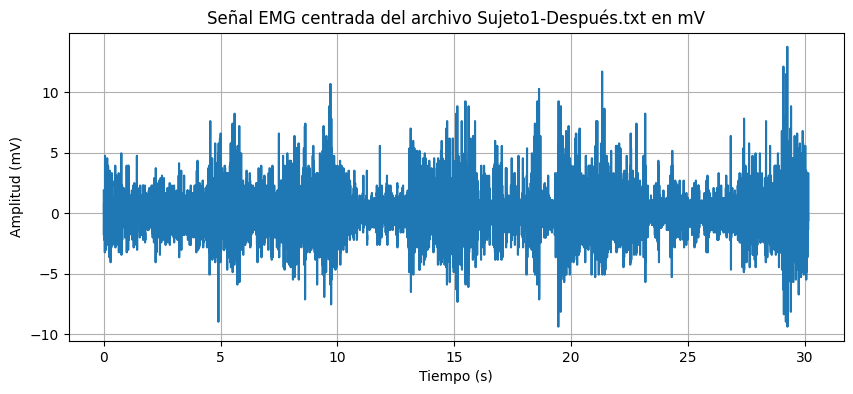

In [6]:
# Load of data
ruta_archivo = "Sujeto1-Después.txt"
data, header = bsnb.load(ruta_archivo, get_header=True)

# Obtener información del canal y el dispositivo
channel = list(data.keys())[0]
device = header["device"]
resolution = int(header["resolution"][0])

# Frecuencia de muestreo y datos adquiridos
fs = header["sampling rate"]

# Convertir la señal a mV
signal = bsnb.raw_to_phy("EMG", device, data[channel], resolution, option="mV")

# Calcular el valor medio de la señal
signal_mean = np.mean(signal)

# Centrar la señal restando el valor medio
signal = signal - signal_mean

# Crear el vector de tiempo
time = np.linspace(0, len(signal) / fs, len(signal))

# Mostrar la señal EMG centrada en función del tiempo
plt.figure(figsize=(10, 4))
plt.plot(time, signal)
plt.title(f'Señal EMG centrada del archivo {ruta_archivo} en mV')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (mV)')
plt.grid(True)
plt.show()

In [7]:
# Función para aplicar los filtros y plotear las respuestas
def aplicar_filtros(emg):
    # Aplicar el filtro IIR
    emg_iir = lfilter(iir_filter[0], iir_filter[1], emg)
    return emg_iir

# Función de wavelet denoising
def wavelet_denoise(imf, wavelet='sym8', level=3):
    coeff = pywt.wavedec(imf, wavelet, mode='per')
    sigma = np.median(np.abs(coeff[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(imf)))
    coeff = list(map(lambda x: pywt.threshold(x, value=uthresh, mode='soft'), coeff))
    return pywt.waverec(coeff, wavelet, mode='per')

# Aplicar el método completo de wavelet denoising
def aplicar_wavelet_denoising(emg_filtrada_iir):
    eemd = EEMD()
    print(f"Aplicando EEMD")
    IMFs = eemd.eemd(emg_filtrada_iir)
    print(f"IMFs obtenidas: {len(IMFs)}")

    # Calcular la función de autocorrelación de cada IMF y sus resultados normalizados
    def autocorr(x):
        result = np.correlate(x, x, mode='full')
        return result[result.size // 2:]

    normalized_autocorr = [autocorr(imf) / np.max(autocorr(imf)) for imf in IMFs]

    # Calcular la varianza de cada función de autocorrelación normalizada para medir el componente de ruido de cada IMF
    variances = [np.var(ac) for ac in normalized_autocorr]

    # Encontrar la IMF límite (ct) a través de la varianza
    threshold = np.mean(variances)  # Es posible que debas ajustar este umbral según tus datos
    high_noise_IMFs = [IMFs[i] for i in range(len(variances)) if variances[i] < threshold]
    low_noise_IMFs = [IMFs[i] for i in range(len(variances)) if variances[i] >= threshold]

    # Procesar ct usando extracción de wavelet y procesar las IMFs de alta frecuencia restantes usando un método mejorado de denoising con wavelet threshold
    denoised_IMFs = [wavelet_denoise(imf) for imf in high_noise_IMFs] + low_noise_IMFs

    # Reconstruir la señal original
    reconstructed_signal = np.sum(denoised_IMFs, axis=0)

    return reconstructed_signal

Aplicando EEMD
IMFs obtenidas: 15


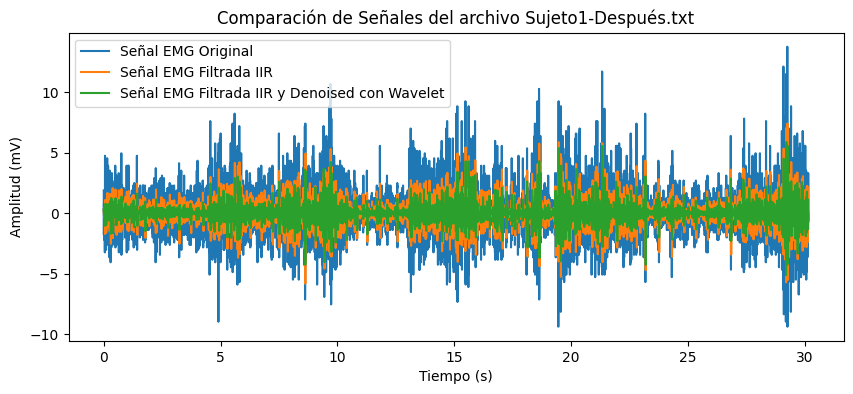

In [8]:
    emg_filtrada_iir = aplicar_filtros(signal)
    # Aplicar el método wavelet denoising
    emg_wavelet_denoised = aplicar_wavelet_denoising(emg_filtrada_iir)

    # Plotear ambas señales en una sola figura para comparación
    tiempo = np.arange(len(emg_wavelet_denoised)) / frecuencia_muestreo
    plt.figure(figsize=(10, 4))
    plt.plot(tiempo, signal, label='Señal EMG Original')
    plt.plot(tiempo, emg_filtrada_iir, label='Señal EMG Filtrada IIR')
    plt.plot(tiempo, emg_wavelet_denoised, label='Señal EMG Filtrada IIR y Denoised con Wavelet')
    plt.title(f'Comparación de Señales del archivo {os.path.basename(ruta_archivo)}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (mV)')
    plt.legend()
    plt.show()

In [9]:
# Detectar activaciones EMG en la señal centrada
signal=emg_wavelet_denoised;
burst_begin, burst_end = bsnb.detect_emg_activations(signal, fs, smooth_level=20, threshold_level=10,
                                                     time_units=True, plot_result=True)[:2]

In [10]:
# Bursts Duration
bursts_time = burst_end - burst_begin

# Parameter extraction
max_time = max(bursts_time)
min_time = min(bursts_time)
avg_time = average(bursts_time)
std_time = std(bursts_time)

print("Características de la duración de los bursts:")
for i, burst_duration in enumerate(bursts_time):
    print(f"Burst {i + 1}: {burst_duration} segundos")

print("\nParámetros estadísticos de la duración de los bursts:")
print(f"Max time: {max_time} segundos")
print(f"Min time: {min_time} segundos")
print(f"Average time: {avg_time} segundos")
print(f"Standard deviation: {std_time} segundos")


Características de la duración de los bursts:
Burst 1: 0.6250207303724826 segundos
Burst 2: 1.1730389067630762 segundos
Burst 3: 0.9070300839165473 segundos
Burst 4: 0.5630186739195331 segundos
Burst 5: 1.6880559885900013 segundos
Burst 6: 0.3590119075259537 segundos
Burst 7: 0.6330209957212496 segundos
Burst 8: 1.1650386414143092 segundos
Burst 9: 0.8750290225214741 segundos
Burst 10: 0.09600318418521425 segundos
Burst 11: 0.3610119738631461 segundos
Burst 12: 0.3580118743573557 segundos
Burst 13: 1.0240339646422747 segundos

Parámetros estadísticos de la duración de los bursts:
Max time: 1.6880559885900013 segundos
Min time: 0.09600318418521425 segundos
Average time: 0.7559481498302014 segundos
Standard deviation: 0.42024802380629755 segundos



Parámetros de la señal EMG:
Maximum EMG: 5.877197170203672
Minimum EMG: -5.116851804649951
Average EMG: 0.011446676794607348
Standard Deviation EMG: 0.6822041231126739


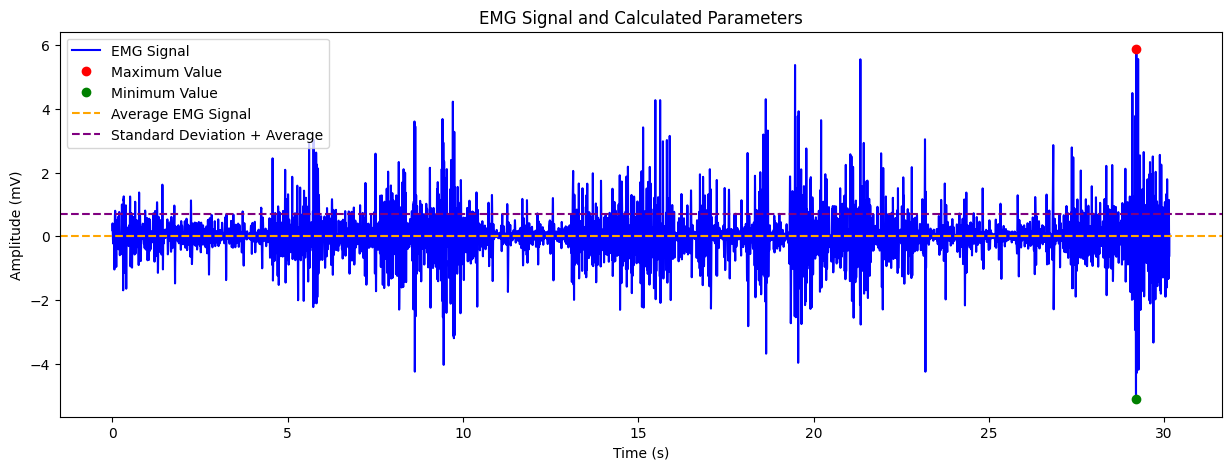

In [11]:
#Parámetros de la señal filtrada

# Maximum
max_sample_value = max(signal)
max_sample_index = np.argmax(signal)

# Minimum
min_sample_value = min(signal)
min_sample_index = np.argmin(signal)

# Average and Standard Deviation
avg_sample_value = average(signal)
std_sample_value = std(signal)

time_param_dict = {"Maximum EMG": max_sample_value, "Minimum EMG": min_sample_value,
                   "Average EMG": avg_sample_value, "Standard Deviation EMG": std_sample_value}

# Imprimir parámetros
print("\nParámetros de la señal EMG:")
for param, value in time_param_dict.items():
    print(f"{param}: {value}")

plt.figure(figsize=(15, 5))
plt.plot(time, signal, label='EMG Signal', color='blue')

# Grafica los parámetros calculados
plt.plot(time[max_sample_index], max_sample_value, 'ro', label='Maximum Value')
plt.plot(time[min_sample_index], min_sample_value, 'go', label='Minimum Value')
plt.axhline(avg_sample_value, color='orange', linestyle='--', label='Average EMG Signal')
plt.axhline(avg_sample_value + std_sample_value, color='purple', linestyle='--', label='Standard Deviation + Average')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('EMG Signal and Calculated Parameters')
plt.legend()
plt.show()

Root Mean Square: 0.6823001480298627
Cumulative Area under the curve: 344.98874541994246


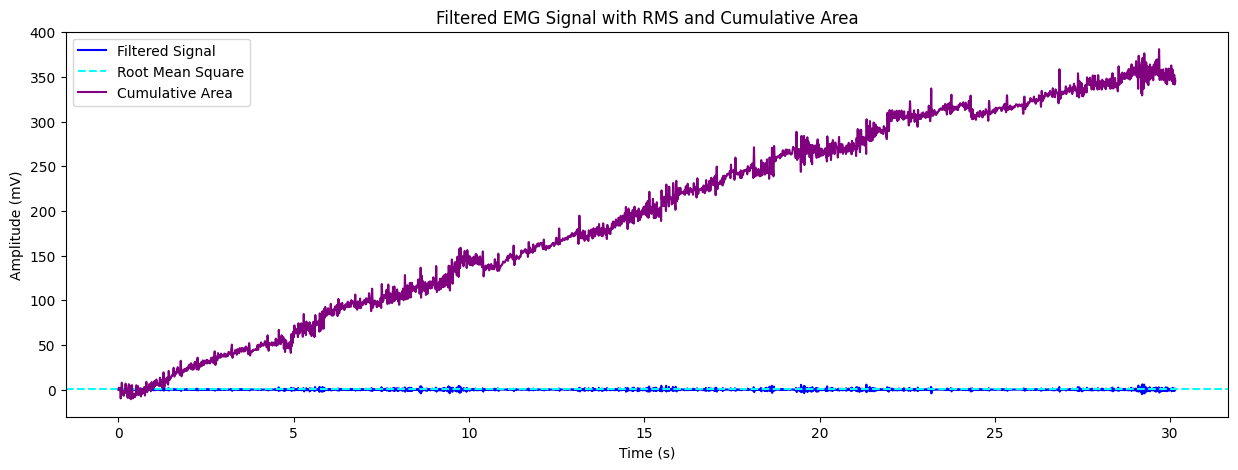

In [13]:
# Root Mean Square
rms = np.sqrt(np.sum(signal ** 2) / len(signal))

# Area under the curve (cumulative)
area = cumtrapz(signal, initial=0)

# Imprimir los valores calculados
print("Root Mean Square:", rms)
print("Cumulative Area under the curve:", area[-1])

# Graficar la señal filtrada, RMS y el área bajo la curva
plt.figure(figsize=(15, 5))
plt.plot(time, signal, label='Filtered Signal', color='blue')
plt.axhline(rms, color='cyan', linestyle='--', label='Root Mean Square')

# Para el área bajo la curva, podemos graficar el área acumulativa
plt.plot(time[:len(area)], area, label='Cumulative Area', color='purple')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Filtered EMG Signal with RMS and Cumulative Area')
plt.legend()
plt.show()

Total Power: 0.43845141083895045
Median Frequency: 35.15625
Frequency of Maximum Power: 42.96875


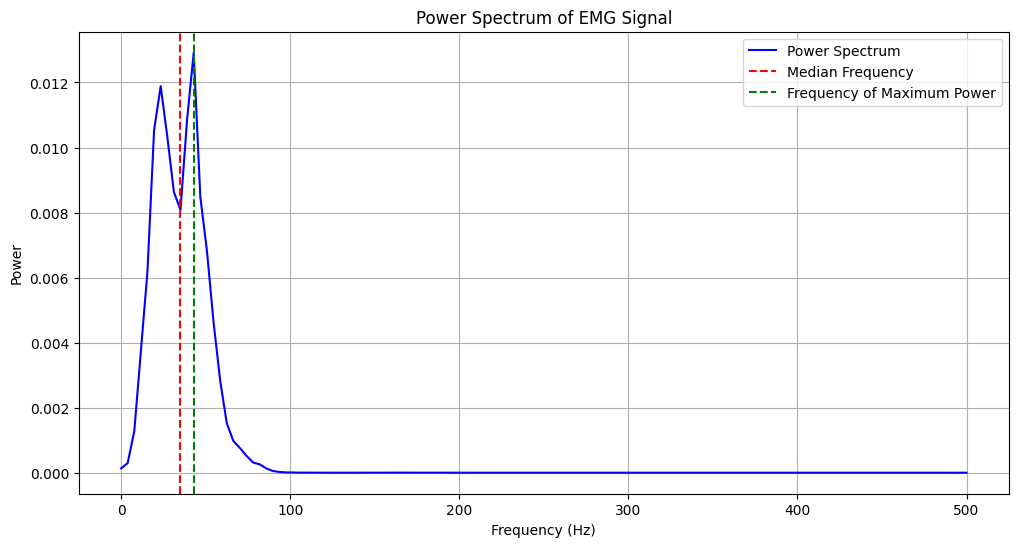

In [14]:
# Signal Power Spectrum
f, P = welch(signal, fs=fs, window='hanning', noverlap=0, nfft=int(256.))

# Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
area_freq = cumtrapz(P, f, initial=0)
total_power = area_freq[-1]
median_freq = f[where(area_freq >= total_power / 2)[0][0]]
f_max = f[argmax(P)]

# Imprimir los valores
print("Total Power:", total_power)
print("Median Frequency:", median_freq)
print("Frequency of Maximum Power:", f_max)

# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Graficar el espectro de potencia
plt.plot(f, P, label='Power Spectrum', color='blue')

# Graficar la frecuencia mediana y la frecuencia máxima
plt.axvline(median_freq, color='red', linestyle='--', label='Median Frequency')
plt.axvline(f_max, color='green', linestyle='--', label='Frequency of Maximum Power')

# Añadir etiquetas y leyenda
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectrum of EMG Signal')
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()


In [16]:
bsnb.emg_parameters(signal, fs, raw_to_mv=False)

{'Number of Muscular Activations': 13,
 'Maximum Muscular Activation Duration': 1.6880559885900013,
 'Minimum Muscular Activation Duration': 0.09600318418521425,
 'Average Muscular Activation Duration': 0.7559481498302014,
 'Standard Deviation of Muscular Activation Duration': 0.42024802380629755,
 'Maximum Sample Value': 5.877197170203672,
 'Minimum Sample Value': -5.116851804649951,
 'Average Sample Value': 0.011446676794607348,
 'Standard Deviation Sample Value': 0.6822041231126739,
 'RMS': 0.6823001480298627,
 'Area': 344.98874541994246,
 'Total Power Spect': 0.43845141083895045,
 'Median Frequency': 35.15625,
 'Maximum Power Frequency': 42.96875}